<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/ORIG_TextAnalysisIMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis & Machine Learning with IMDb

We'll build a function to scrape movie reviews and ratings for a monthly highlights page at IMDb.com and then use machine learning based on inductive data (tokens from the reviews, unspecified in advance) to predict movie ratings.

BLOCK 1. Installing and loading relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
import requests # This is the library for embedding HTTP calls in the notebook
from random import sample
import scipy as sp
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


In [2]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Block 1d: BeautifulSoup is a useful library for extracting HTML elements
!pip install bs4
from bs4 import BeautifulSoup

In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')    # This is a useful way to remove non-content function words from the data.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
wnl = nltk.WordNetLemmatizer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))


BLOCK 2. Data acquisition.

First, we get the text from the monthly highlights page. The structure of IMDb pages is complex, so we have to find the parts of the page that contain the information we want to model. Here, we're getting the movie information, the review, and the rating.

To get more text data, we could make a list of URLs and then iterate this process over the list.

In [10]:
URL = 'https://www.imdb.com/list/ls523796298/?ref_=hm_edcft_c_ft_nov23_high_1_cta' # Here, we specify the page we want to start with

try:  #get command is sent to browser to get a page
      # Beautiful Soup takes the data, parses it nad makes it a soup object
    response = requests.get(URL)
    topic_soup = BeautifulSoup(response.content, 'html.parser')

except:
    print("Can not open " + URL + ".")


**The code below doesn't work**

In [8]:
topic_soup  #got 403 website b/c server rejects request b/c we didn't mimic a browser. #IMDB can't respond with cookies for tracking

<html>
<head><title>403 Forbidden</title></head>
<body>
<center><h1>403 Forbidden</h1></center>
</body>
</html>

In [9]:
movies_df = pd.DataFrame()
review_series = pd.Series()
topic_paragraphs = []
tokens = []
corpus= []
title = ''
rating = 0

# Use search function in beautiful soup to parse HTML, supposed to take the text and ratingsn and vectorize them
for movie in topic_soup.find_all(class_=re.compile("ipc-metadata-list")):
    for para in movie.find_all('div'):
        text = para.get_text(strip=True)
        topic_paragraphs.append(text)
    if movie.find('div', class_=re.compile("ipc-metadata-list-summary-item")):
        rating = movie.find('span', class_="ipc-rating-star--rating").get_text()
    for tag in movie.find_all('h3', class_="ipc-title__text"):
        title = tag.get_text(strip=True)
    tokens = [wnl.lemmatize(t.lower()) for t in nltk.word_tokenize(str(topic_paragraphs)) if t not in en_stop_words]
    review = ' '.join(tokens)
    corpus.append(review)
    review_series = pd.Series([title, tokens, rating], index=['title', 'tokens', 'rating'])
    movies_df = movies_df.append(review_series, ignore_index=True)
    topic_paragraphs = []
    tokens = []

movies_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


BLOCK 3. Data preparation.

Here, we take the text data we scraped and create a corpus data object and then a document-term matrix. (In this case, the "documents" are the paragraphs we scraped.) The dtm data are used to compute distances based on co-occurrence.

In [11]:
vectorizer = CountVectorizer(
    min_df=0.05,
    max_df=0.98,
    stop_words='english',
    ngram_range=(1,2)
    )

topic_tm = vectorizer.fit_transform(corpus)

topic_feature_names = vectorizer.get_feature_names_out()

topic_dtm = pd.DataFrame(topic_tm.todense(), columns=topic_feature_names)

topic_dtm.head()

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
topic_tokens_present = np.where(topic_dtm.max() > 1 , True, False)
topictokenslimited_df = topic_dtm.loc[:, topic_tokens_present]
nullwords = ["wikipedia", "copyright", "10", '12']
for term in nullwords:
    topictokenslimited_df = topictokenslimited_df.drop(columns=[i for i in list(topictokenslimited_df.columns) if term in i])
topictokenslimited_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 53 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   action        26 non-null     int64
 1   adventure     26 non-null     int64
 2   animation     26 non-null     int64
 3   apple         26 non-null     int64
 4   apple tv      26 non-null     int64
 5   brother       26 non-null     int64
 6   cera          26 non-null     int64
 7   chris         26 non-null     int64
 8   colman        26 non-null     int64
 9   comedy        26 non-null     int64
 10  david         26 non-null     int64
 11  director      26 non-null     int64
 12  drama         26 non-null     int64
 13  dream         26 non-null     int64
 14  elizabeth     26 non-null     int64
 15  elordi        26 non-null     int64
 16  emma          26 non-null     int64
 17  fassbender    26 non-null     int64
 18  father        26 non-null     int64
 19  film          26 non-null     i

In [ ]:
keyword_cofreq = topictokenslimited_df.T.dot(topictokenslimited_df)
keyword_dist = 1/(keyword_cofreq+1)
keyword_dist  # distance matrix

,action,adventure,animation,apple,apple tv,brother,cera,chris,colman,comedy,...,star,story,team,theater,thriller,town,tv,world,year,young
action,0.083333,0.083333,0.250000,0.333333,0.333333,1.000000,0.200000,1.000000,1.000000,1.000000,...,1.000000,0.250000,0.500000,0.200000,0.500000,0.333333,0.333333,0.250000,0.333333,0.333333
adventure,0.083333,0.066667,0.111111,0.333333,0.333333,0.250000,0.200000,0.333333,1.000000,0.333333,...,0.250000,0.250000,0.333333,0.142857,0.333333,0.333333,0.333333,0.250000,0.250000,0.250000
animation,0.250000,0.111111,0.050000,1.000000,1.000000,0.333333,0.333333,0.111111,1.000000,0.166667,...,0.111111,0.500000,0.200000,0.166667,1.000000,0.500000,1.000000,0.500000,0.200000,0.200000
apple,0.333333,0.333333,1.000000,0.166667,0.166667,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667,0.333333,1.000000,1.000000
apple tv,0.333333,0.333333,1.000000,0.166667,0.166667,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.166667,0.333333,1.000000,1.000000
brother,1.000000,0.250000,0.333333,1.000000,1.000000,0.166667,1.000000,1.000000,1.000000,0.333333,...,0.500000,1.000000,1.000000,0.333333,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000
cera,0.200000,0.200000,0.333333,1.000000,1.000000,1.000000,0.166667,1.000000,1.000000,0.333333,...,1.000000,0.250000,1.000000,0.500000,1.000000,0.333333,1.000000,0.333333,1.000000,1.000000
chris,1.000000,0.333333,0.111111,1.000000,1.000000,1.000000,1.000000,0.142857,0.333333,0.333333,...,0.200000,0.500000,0.333333,0.250000,1.000000,1.000000,1.000000,1.000000,0.250000,0.333333
colman,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.166667,1.000000,...,1.000000,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1.000000
comedy,1.000000,0.333333,0.166667,1.000000,1.000000,0.333333,0.333333,0.333333,1.000000,0.052632,...,0.250000,0.111111,0.125000,0.111111,0.250000,0.333333,1.000000,0.500000,0.500000,0.333333


BLOCK 4. Analysis and visualization.

In [ ]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
pca = PCA(n_components=2)
keywords_transform = mds.fit_transform(keyword_dist)
print(keywords_transform)
print(mds.stress_)

[[ 0.17823222 -0.07149448]
 [-0.43453211  0.18079125]
 [-0.2084357  -0.07522892]
 [ 0.08025914  0.33951868]
 [ 0.11858532  0.38168187]
 [-0.20558066  0.26566383]
 [-0.26407412  0.35779067]
 [ 0.25265554 -0.16579793]
 [ 0.4058256   0.14316861]
 [-0.33222004 -0.18036466]
 [ 0.00681339 -0.47901348]
 [-0.31655542 -0.06401378]
 [-0.14205051 -0.01367511]
 [-0.29470855  0.10282151]
 [ 0.39741725 -0.2843447 ]
 [ 0.018609   -0.34427102]
 [ 0.24706239 -0.03311416]
 [ 0.09660537 -0.23832713]
 [-0.37971104  0.01557397]
 [-0.09083789  0.42631366]
 [ 0.26773216  0.23897309]
 [ 0.44440008 -0.35888399]
 [ 0.08052466  0.09821281]
 [ 0.47356041 -0.14065317]
 [-0.34269252 -0.30620096]
 [-0.49796586  0.40815325]
 [ 0.18201665  0.30352314]
 [-0.27221416  0.1242649 ]
 [-0.47214375  0.04191691]
 [ 0.47878646  0.38815911]
 [-0.13829048  0.49917274]
 [-0.27065427  0.47049844]
 [ 0.49116592  0.28548995]
 [ 0.13235739  0.42171142]
 [-0.22776287  0.3791808 ]
 [ 0.15249667 -0.64398919]
 [-0.25701581 -0.36063493]
 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


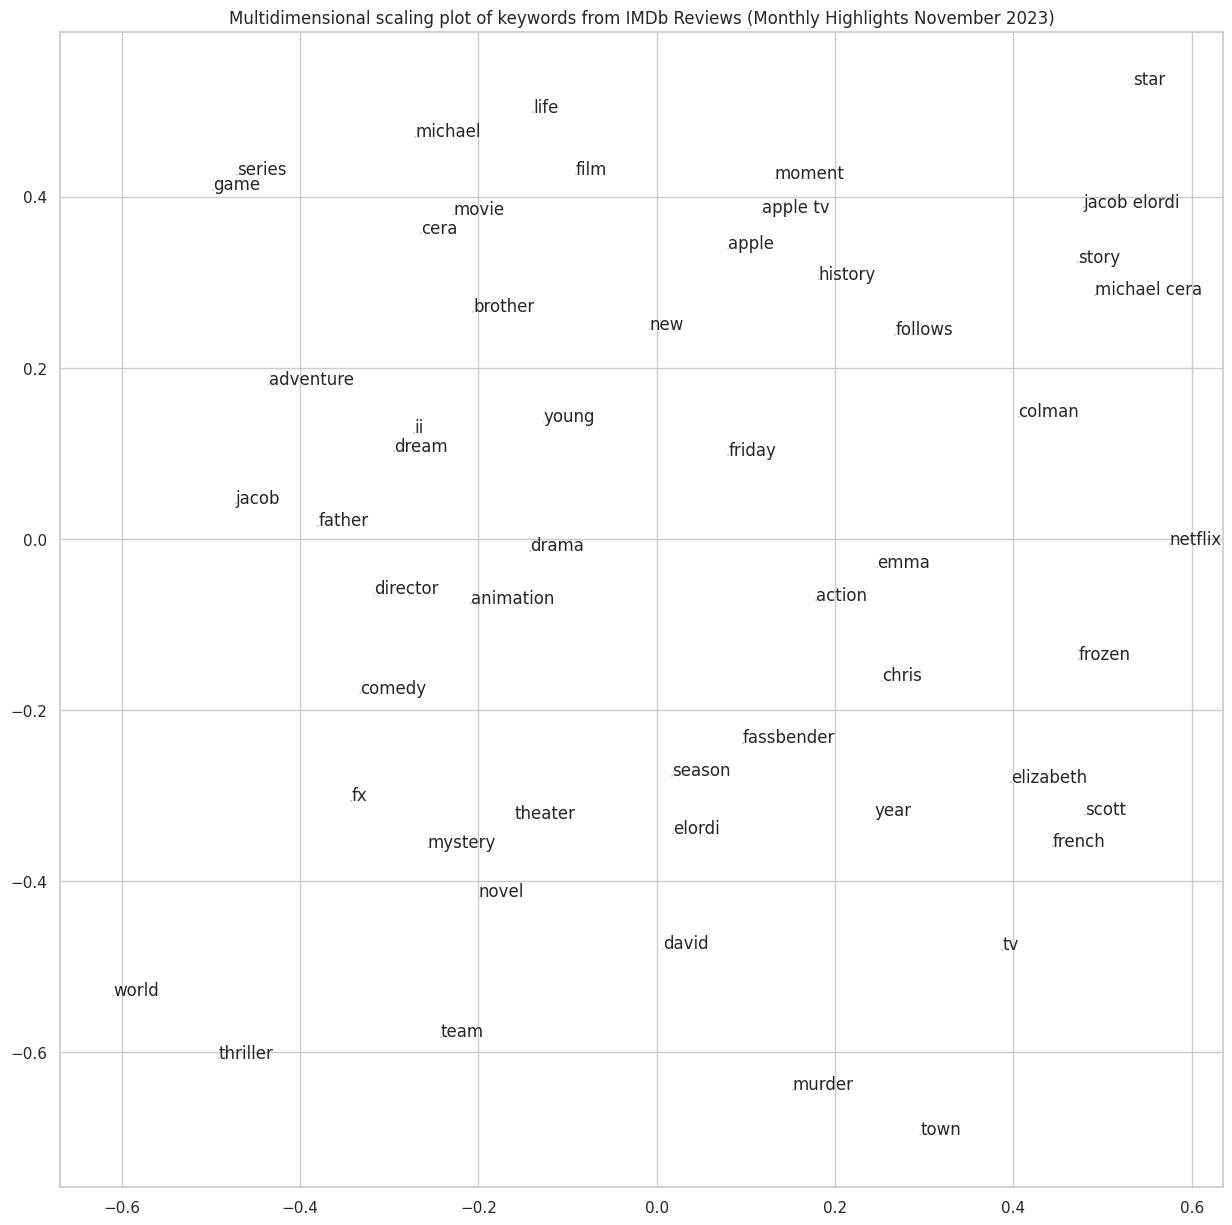

In [ ]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15,15))
i = 0
while i < len(topictokenslimited_df.columns):
    plt.scatter(keywords_transform[i,0], keywords_transform[i,1], sizes=(1, 1), marker='+', c='lightgrey')
    plt.text(keywords_transform[i,0], keywords_transform[i,1], topictokenslimited_df.columns[i])
    i += 1
plt.title('Multidimensional scaling plot of keywords from IMDb Reviews (Monthly Highlights November 2023)')
plt.show()

In [ ]:
topictokenslimited_df['rating'] = movies_df['rating']

In [ ]:
topictokenslimited_df['rating'] = topictokenslimited_df['rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
topictokenslimited_df['score'] = 0
topictokenslimited_df.loc[topictokenslimited_df['rating'] < topictokenslimited_df.rating.median(), ['score']] = 1
topictokenslimited_df['score'].describe()

count    26.000000
mean      0.500000
std       0.509902
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000
Name: score, dtype: float64

In [ ]:
# Feed the data into machine learning model
model_data_Y = topictokenslimited_df['rating']
model_data_X = topictokenslimited_df.drop(['score','rating'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)
from sklearn.linear_model import LinearRegression
model0 = LinearRegression().fit(X_train, y_train)
model0_pred = model0.predict(X_test)

from sklearn.metrics import r2_score
print("Coefficients: \n", model0.coef_)
print("Coefficient of determination: %.2f" % r2_score(y_test, model0_pred))

Coefficients: 
 [ 4.29446957e-03 -5.27763573e-02  2.03112806e-01  2.63977295e-01
  2.63977295e-01 -2.87028539e-01  4.31571210e-02 -1.11011256e-01
 -2.77555756e-17  1.11939011e-01 -1.18763848e-01 -2.16859711e-01
 -3.18448333e-02  3.70106330e-02 -1.79202076e-02  0.00000000e+00
 -1.66437086e-01  1.87681324e-03  2.94402269e-02  9.08859672e-02
  1.08270875e-01  6.61915371e-01 -1.03361404e-01  1.72886885e-01
  1.92548137e-03  6.65436451e-02 -1.51577992e-02  1.24908040e-02
  0.00000000e+00  0.00000000e+00  2.13068475e-01  2.87192709e-01
  4.31571210e-02 -2.83898141e-01  3.94972324e-01  1.92548137e-03
 -4.81089241e-02 -9.47312724e-02 -7.25518287e-02 -1.24429500e-03
  3.31525638e-01  3.14343758e-01  1.46028107e-01  1.37218897e-01
  2.37271078e-02 -1.65203867e-01 -3.07831398e-01 -1.35178430e-01
 -1.79248152e-01  2.63977295e-01 -8.29127423e-02  3.80512605e-01
  4.94671233e-02]
Coefficient of determination: -0.79


In [ ]:
# MOdel was pretty accurate (78%)
model_data_Y = topictokenslimited_df['score']
model_data_X = topictokenslimited_df.drop(['score','rating'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)
from sklearn.svm import LinearSVC
model1 = LinearSVC(C = 10, max_iter = 10000000).fit(X_train, y_train)
model1_pred = model1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model1_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.77         9
weighted avg       0.85      0.78      0.77         9



## Activity

Let's see if we can improve on the classification model.
